In [ ]:
#%reset -f
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask as da
import glob
import time
from datetime import datetime, timedelta as delta
from matplotlib import path
from matplotlib.collections import PolyCollection #for plots polygons as rasters
#for animation
import matplotlib.animation as animation
from copy import deepcopy
import matplotlib as mpl
import time
import tqdm #to see progressbar for loops
from scipy.spatial import KDTree, cKDTree #c implementation is faster (to find neighbor)
%matplotlib inline
# to see the plot labels when using jupyter-lab dark mode
from matplotlib import style
#style.use('classic') #like matlab style (gray background, but white when saving figures)
#style.use('ggplot')
style.use('default') #the above styles problems with PolyCollection 
#print(style.available) #to see the styles 
import pickle #to save data as binary file .pkl
from windrose import WindroseAxes
import seaborn as sns #for heat maps of correlation and RMSD
from itertools import product #to make all possible permutations including repeated values
#
from scipy.interpolate import griddata #interpolation in space for non-uniform grids
from scipy.interpolate import interp1d #1d interp

#for projections
from pyproj import Proj, transform, Transformer

In [2]:
dir_winds="/export/lv4/user/jfajardourbina/dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
year=2009
file_winds=f"UERRA.{year}.nc4" #to make some simple test
dir_dws_bound="/export/lv4/user/jfajardourbina/dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
file_dws_bound0="dws_boundaries_contour0.nc"
file_grid="/export/lv4/user/jfajardourbina/dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
dir_vel = '/export/lv4/user/jfajardourbina/dws_ulf_getm_2D_depth_avg/data/velocity/' #vel data
file_vel="RE.DWS200m.uvz.20090301.nc"
#
homee = "/export/lv4/user/jfajardourbina/"
savee='everyM2' #saving track data every m2
deploy='everyM2'#deploy set of particles every m2
minTsim=60 #mimimum time of simulation (days)
maxTsim=91 #maximum time of simulation (days)
dir_tracks = f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
#
npa_per_dep=12967 #number of particles per deployment
m2=int(12.42*3600+2) #period in seconds
ref_time=np.datetime64("1980-01-01") #reference time for time interpolation
dx=400/1e3;dy=400/1e3 #particle grid reso

In [3]:
dir_post_proc_forcing="post_proc_data/" #to save some wind post_proc files
post_proc_forcing_file_all_domain=f'{year}_wind_data_every_m2_in_positions_of_deployments.nc'

In [4]:
dsw=xr.open_dataset(dir_winds+file_winds) #winds
tw = dsw.time.values #contains data for the full 1st day of the next year

dsto=xr.open_dataset(file_grid+"DWS200m.2012.v03.nc") #topo file
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)

dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0

#open vel data
dsv=xr.open_dataset(dir_vel+file_vel)
xcv=dsv.xc; ycv=dsv.yc; hv=dsv.bathymetry.load()
xcv0=xcv.min().values/1e3; ycv0=ycv.min().values/1e3

In [5]:
#open first and last track---
#the last track should be the first of the following year
#so we can compute the avg wind on the interval of the last net displacement
month_sim=1
file_track=f'tracks_{year}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year}/{file_track}'  
dst=xr.open_dataset(file_track_path)
t0=dst.time.isel(traj=0,obs=0).values 
x0=dst.x.isel(traj=range(npa_per_dep),obs=0).values
y0=dst.y.isel(traj=range(npa_per_dep),obs=0).values
del dst
#
month_sim=1
file_track=f'tracks_{year+1}{month_sim:02d}_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d.nc'
file_track_path=f'{dir_tracks}{year+1}/{file_track}'  
t1=xr.open_dataset(file_track_path).time.isel(traj=0,obs=0).values
#print(t0,t1)

In [6]:
#times to get wind data for this year---
nt_int=283*2 #get wind data every 9.43 min (divisor of m2=44714)
t_int=np.arange(t0,t1+np.timedelta64(1,'s'),nt_int,dtype='datetime64[s]') #data until next year (to make avg during the interval of net displacement)
t_dep=np.arange(t0,t1,m2,dtype='datetime64[s]') #only for this year

In [7]:
#index from the model topo grid units from which the velocity y-axis start and finish
#the model of the simulation is shorter in the y-axis than the full topo domain
iy0=np.nonzero(dsto.yc.values==dsv.yc[0].values)[0][0]
print(iy0,dsto.yc.values[iy0],dsv.yc.values[0])
iy1=np.nonzero(dsto.yc.values==dsv.yc[-1].values)[0][0]
print(iy1,dsto.yc.values[iy1],dsv.yc.values[-1])

99 19800.0 19800.0
479 95800.0 95800.0


In [127]:
#define the transformations----------
#1)
#from epgs:28992(DWS) to epgs:4326(LatLon with WGS84 datum used by GPS and Google Earth)
proj = Transformer.from_crs('epsg:28992','epsg:4326',always_xy=True)
#2)
#from epgs:4326(LatLon with WGS84) to epgs:28992(DWS) 
inproj = Transformer.from_crs('epsg:4326','epsg:28992',always_xy=True)
#inproj_old=Proj("EPSG:28992") #old method (has errors 10-20m when contrast with the rotated coords)

#lon,lat to 28992(DWS)-projection--------------------

#bathymetry--------
xct=dsto.lonc.values;  yct=dsto.latc.values #lon,lat units
xctp,yctp,z = inproj.transform(xct,yct,xct*0.)
#[xctp,yctp] = inproj_old(xct,yct) #old method
xctp=(xctp)/1e3; yctp=(yctp)/1e3 
#first projected point to correct the coordinates of model local meter units
xctp0=xctp[0,0]; yctp0=yctp[0,0]

#wind data--------
#use the full domain---
#usually problems when using local projection for big domains, but for our case no problems
xc,yc=np.meshgrid(dsw.lon.values,dsw.lat.values)
xcw,ycw,z = inproj.transform(xc,yc,xc*0.)
xcw=xcw/1e3; ycw=ycw/1e3
#xcw=(xcw-xcw[0,0])/1e3; ycw=(ycw-ycw[0,0])/1e3
#use a short domain around DWS---
xc2,yc2=np.meshgrid(dsw.lon.sel(lon=slice(4,6.5)).values,dsw.lat.sel(lat=slice(52.5,53.75)).values)
xcw2,ycw2,z = inproj.transform(xc2,yc2,xc2*0.)
xcw2=(xcw2)/1e3; ycw2=(ycw2)/1e3

#matrix rotation -17degrees-----
ang=-17*np.pi/180
angs=np.ones((2,2))
angs[0,0]=np.cos(ang); angs[0,1]=np.sin(ang)
angs[1,0]=-np.sin(ang); angs[1,1]=np.cos(ang)


#local meter model units to 28992(DWS)-projection and lon-lat--------------

#bathymetry----
#original topo points in meter
xct2,yct2=np.meshgrid(dsto.xc.values,dsto.yc.values)
xy=np.array([xct2.flatten(),yct2.flatten()]).T
#rotate
xyp=np.matmul(angs,xy.T).T/1e3
xyp0=xyp[0,:] #the first point in the bathy data in local meter units=0,0
#correct model units:
#1)substact the first model local point of the topo file, but give tha same as xyp0=[0,0]
#2)use the first projected point of the case (lon,lat model units to meter)
xyp=xyp-xyp0 
xyp[:,0]=xyp[:,0]+xctp0; xyp[:,1]=xyp[:,1]+yctp0 
xyp=np.reshape(xyp,(len(dsto.yc.values),len(dsto.xc.values),2))
xctp2=xyp[...,0]; yctp2=xyp[...,1] #km
#
#contrast projections (lon,lat model units to meter) with rotated case
#around 0 meter diff with new method
#10 meter difference in average and maximum of 20 with old method
a=xctp-xctp2; b=yctp-yctp2
print(np.abs(a).max()*1e3, np.abs(b).max()*1e3, np.abs(a).mean()*1e3, np.abs(b).mean()*1e3) 

#contour0 of DWS------
#rotate
bdr_dws0p=np.matmul(angs,bdr_dws0.T).T/1e3
#correct model units:
#1)substact the first model local point of the topo file, but give tha same as xyp0=[0,0]
#2)use the first projected point of the case (lon,lat model units to meter)
bdr_dws0p=bdr_dws0p-xyp0 
bdr_dws0p[:,0]=bdr_dws0p[:,0]+xctp0; bdr_dws0p[:,1]=bdr_dws0p[:,1]+yctp0
#
#get coordinates in lon-lat units (WGS84 ) 
bdr_dws0_lon, bdr_dws0_lat, z = proj.transform(bdr_dws0p[:,0]*1e3,bdr_dws0p[:,1]*1e3, bdr_dws0p[:,1]*0.)


#now try to express from lon-lat to local model units

#matrix rotation 17degrees-----
ang=17*np.pi/180
angs2=np.ones((2,2))
angs2[0,0]=np.cos(ang); angs2[0,1]=np.sin(ang)
angs2[1,0]=-np.sin(ang); angs2[1,1]=np.cos(ang)


#28992(DWS)-projection to local meter model units--------------

#batymetry and interpolated wind---
xy=np.array([xctp.flatten(),yctp.flatten()]).T #km
#xy=xy-xy[0]
ny,nx=xctp.shape
#rotate
xyl=np.matmul(angs2,xy.T).T
xyl0=xyl[0,:] #the first point 
#correct model units:
#1)substact the first model local point of the topo file, but give tha same as xyp0=[0,0]
#2)use the first projected point of the case (lon,lat model units to meter)
xyl=xyl-xyl0 
xyl[:,0]=xyl[:,0]+xct0; xyl[:,1]=xyl[:,1]+yct0 
xyl=np.reshape(xyl,(ny,nx,2))
xctl=xyl[...,0]; yctl=xyl[...,1] #km

#errors in the position when using the local values get from transforamtion (around 0.1% of the grid size)
a=abs(xctl*1e3-dsto.xc.values)
b=abs(yctl.T*1e3-dsto.yc.values)
print('max, mean, max% errors in x (m)',a.max(), a.mean(), a.max()/200*100,"%") # max=12cm, mean=5cm
print('max, mean, max% errors in y (m)',b.max(), b.mean(), b.max()/200*100,"%") # max=32cm, mean=13cm

#select mid point of texel-------
xymid=np.expand_dims(dsb0.tr_dws_marsdiep[len(dsb0.tr_dws_marsdiep)//2].values,1).T
xymidp=np.matmul(angs,xymid.T).T/1e3 #rotate
#correct model units
xymidp=xymidp-xyp0; xymidp[:,0]=xymidp[:,0]+xctp0; xymidp[:,1]=xymidp[:,1]+yctp0
#get coordinates in lon-lat units (WGS84) 
xymidp_lon, xymidp_lat, z = proj.transform(xymidp[:,0]*1e3,xymidp[:,1]*1e3, xymidp[:,1]*0.)
#find nearest point for wind--------
ixt=np.argmin(abs(dsw.lon.values-xymidp_lon))+1 #to consider the point inside DWS (the nearest is outside) 
iyt=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
print(xymidp_lon, dsw.lon[ixt].values, xymidp_lat, dsw.lat[iyt].values)

#select last point of vlie-------
xymid=np.expand_dims(dsb0.tr_dws_vlie[0,:].values,1).T
xymidp=np.matmul(angs,xymid.T).T/1e3 #rotate
#correct model units
xymidp=xymidp-xyp0; xymidp[:,0]=xymidp[:,0]+xctp0; xymidp[:,1]=xymidp[:,1]+yctp0
#get coordinates in lon-lat units (WGS84) 
xymidp_lon, xymidp_lat, z = proj.transform(xymidp[:,0]*1e3,xymidp[:,1]*1e3, xymidp[:,1]*0.)
#find nearest point for wind--------
ixv=np.argmin(abs(dsw.lon.values-xymidp_lon)); iyv=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
print(xymidp_lon, dsw.lon[ixv].values, xymidp_lat, dsw.lat[iyv].values)

#eastern DWS (low mean)-------
xymidp_lat=53.4; xymidp_lon=5.8
ixedw=np.argmin(abs(dsw.lon.values-xymidp_lon)); iyedw=np.argmin(abs(dsw.lat.values-xymidp_lat))
#lon diff 0.08 (around 10 km difference, approx reso of wind data)
print(xymidp_lon, dsw.lon[ixedw].values, xymidp_lat, dsw.lat[iyedw].values)

0.026940217722426496 0.3400088997977946 0.009365292291273685 0.1443332403121348
max, mean, max% errors in x (m) 0.12412859736627979 0.04687436167418282 0.062064298683139896 %
max, mean, max% errors in y (m) 0.32751821742022 0.13691407317063156 0.16375910871011 %
[4.78538806] 4.92 [52.98636721] 52.98
[5.09445047] 5.14 [53.30634619] 53.31
5.8 5.8 53.4 53.42


In [9]:
#create mask for islands
h=dsto.bathymetry; mask=h.where(np.isnan(h),1); mask=mask.where(np.isfinite(h),0)

### Test for the avg velocity of this month

/tmp/ipykernel_14808/2429675454.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[1].pcolormesh(xcw,ycw,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation


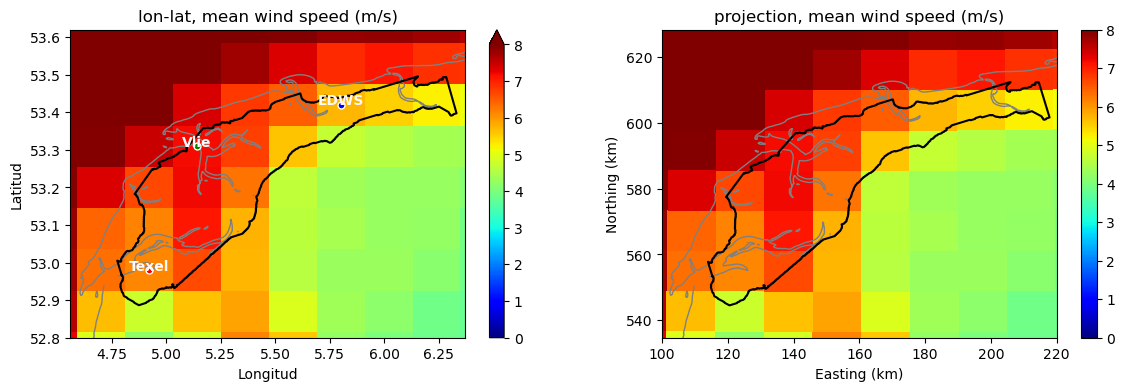

In [148]:
fig,ax= plt.subplots(1,2,figsize=(14,4))

ws=(dsw.u10**2+dsw.v10**2)**.5
ws_avg=ws.mean(dim='time') #avg for 2009

ws_avg.plot.pcolormesh(ax=ax[0],vmin=0,vmax=8,shading='auto',cmap='jet')#wind-energy lon-lat
ax[0].contour(xct,yct,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy in lon-lat from topo file 
ax[0].plot(bdr_dws0_lon,bdr_dws0_lat,'k') #DWS limits in lon-lat
ax[0].axis([4.56,6.37,52.8,53.62]);ax[0].set_xlabel('');ax[0].set_ylabel('')
ax[0].set_title('lon-lat, mean wind speed (m/s)')
ax[0].plot(dsw.lon[ixt],dsw.lat[iyt],'or',markersize=5,markeredgecolor='w') 
ax[0].text(dsw.lon[ixt],dsw.lat[iyt],'Texel',color='snow',weight='bold',ha='center') 
ax[0].plot(dsw.lon[ixv],dsw.lat[iyv],'og',markersize=5,markeredgecolor='w') 
ax[0].text(dsw.lon[ixv],dsw.lat[iyv],'Vlie',color='snow',weight='bold',ha='center') 
ax[0].plot(dsw.lon[ixedw],dsw.lat[iyedw],'ob',markersize=5,markeredgecolor='w') 
ax[0].text(dsw.lon[ixedw],dsw.lat[iyedw],'EDWS',color='snow',weight='bold',ha='center')
ax[0].set_xlabel('Longitud');ax[0].set_ylabel('Latitud');
#
aa=ax[1].pcolormesh(xcw,ycw,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax[1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1].axis('equal');ax[1].axis([100,220,543,620])
ax[1].set_xlabel('Easting (km)');ax[1].set_ylabel('Northing (km)');
plt.colorbar(aa)
ax[1].set_title('projection, mean wind speed (m/s)');

In [57]:
#Interpolate projected wind data into projected model grid------

#using grid data----
#because our wind data is to low resolution in contrast with model grid
#cubic spline interpolation seems more suitable
points=np.array([xcw.flatten(),ycw.flatten()]).T
values=ws_avg.values.flatten()
values_int_ne = griddata(points, values, (xctp, yctp), method='nearest')
values_int_li = griddata(points, values, (xctp, yctp), method='linear')
values_int = griddata(points, values, (xctp, yctp), method='cubic')
np.sum(np.isnan(values_int_ne)),np.sum(np.isnan(values_int_li)),np.sum(np.isnan(values_int))

#
# Interp2d does not work with non rectangular grids---
# from scipy import interpolate
# f = interpolate.interp2d(xcw.flatten(), ycw.flatten(), ws_avg.values, kind='linear')
# xctp_fla=xctp.flatten(); yctp_fla=yctp.flatten()
# xcw_tp = f(xctp_fla, yctp_fla)

(0, 0, 0)

/tmp/ipykernel_39733/2668961791.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[0,0].pcolormesh(xcw,ycw,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation


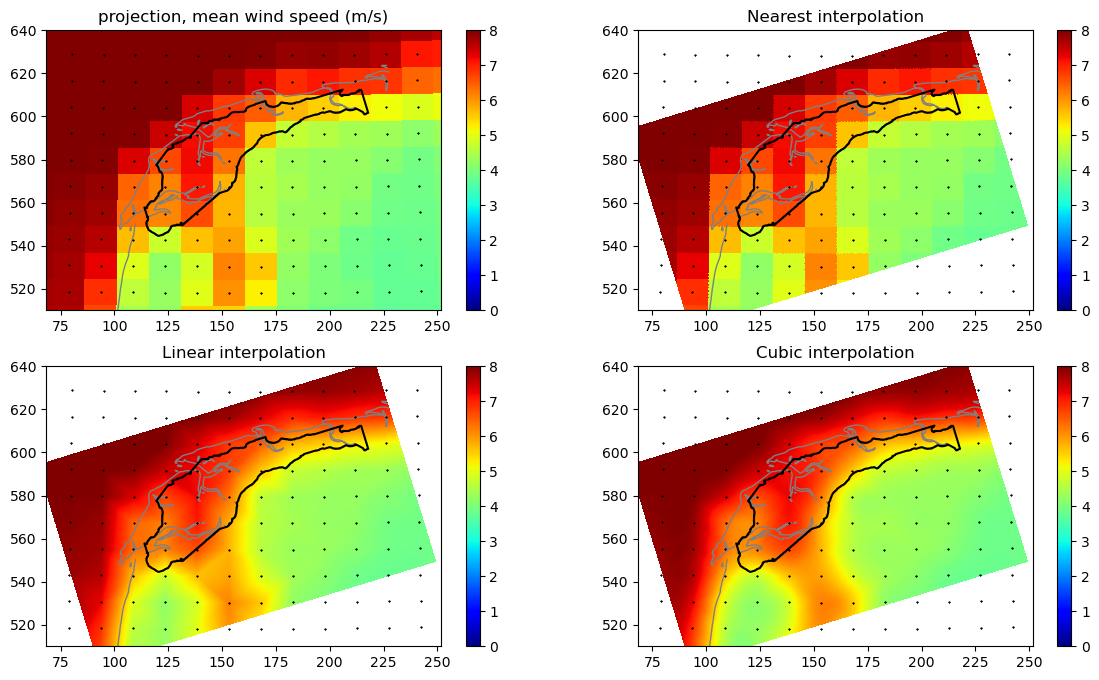

In [122]:
a=xcw.flatten();b=ycw.flatten()

fig,ax= plt.subplots(2,2,figsize=(14,8))

#aa=ax[0,0].contourf(xcw,ycw,ws_avg.values,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[0,0].pcolormesh(xcw,ycw,ws_avg.values,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax[0,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,0].axis('equal');ax[0,0].axis([70,250,510,640])#;ax[0,0].axis([100,220,540,620])
#plt.axis([100,120,540,560])
plt.colorbar(aa,ax=ax[0,0])
ax[0,0].plot(a,b,'*k',ms=1)
ax[0,0].set_title('projection, mean wind speed (m/s)')
#
#aa=ax[0,1].contourf(xctp,yctp,values_int_ne,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[0,1].pcolormesh(xctp,yctp,values_int_ne,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax[0,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[0,1].axis('equal');ax[0,1].axis([70,250,510,640])#;ax[0,1].axis([100,220,540,620])
#plt.axis([100,120,540,560])
plt.colorbar(aa,ax=ax[0,1])
ax[0,1].plot(a,b,'*k',ms=1)
ax[0,1].set_title('Nearest interpolation');
#
#aa=ax[1,0].contourf(xctp,yctp,values_int_li,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[1,0].pcolormesh(xctp,yctp,values_int_li,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax[1,0].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,0].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,0].axis('equal');ax[1,0].axis([70,250,510,640])#;ax[1,0].axis([100,220,540,620])
#plt.axis([100,120,540,560])
plt.colorbar(aa,ax=ax[1,0])
ax[1,0].plot(a,b,'*k',ms=1)
ax[1,0].set_title('Linear interpolation');
#
#aa=ax[1,1].contourf(xctp,yctp,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[1,1].pcolormesh(xctp,yctp,values_int,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax[1,1].contour(xctp,yctp,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1,1].plot(bdr_dws0p[:,0],bdr_dws0p[:,1],'k') #DWS limits
ax[1,1].axis('equal');ax[1,1].axis([70,250,510,640])#;ax[1,1].axis([100,220,540,620])
#plt.axis([100,120,540,560])
plt.colorbar(aa,ax=ax[1,1])
ax[1,1].plot(a,b,'*k',ms=1)
ax[1,1].set_title('Cubic interpolation');

/tmp/ipykernel_39733/755552615.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  aa=ax[0].pcolormesh(xctl,yctl,values_int,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation


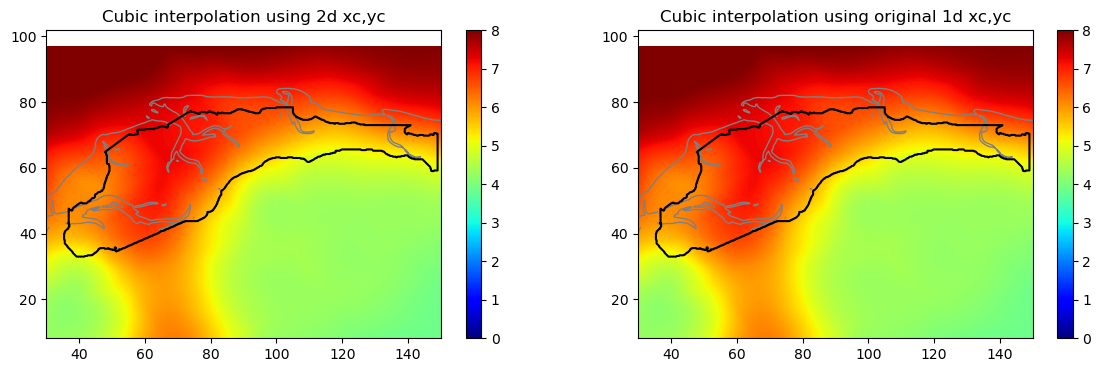

In [154]:
fig,ax= plt.subplots(1,2,figsize=(14,4))

#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[0].pcolormesh(xctl,yctl,values_int,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax[0].contour(xctl,yctl,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax[0].axis('equal');ax[0].axis([30,150,30,80])
#plt.axis([100,120,540,560])
plt.colorbar(aa,ax=ax[0])
ax[0].set_title('Cubic interpolation using 2d xc,yc');
#
#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax[1].pcolormesh(dsto.xc.values/1e3,dsto.yc.values/1e3,values_int,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax[1].contour(dsto.xc.values/1e3,dsto.yc.values/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax[1].axis('equal');ax[1].axis([30,150,30,80])
#plt.axis([100,120,540,560])
plt.colorbar(aa,ax=ax[1])
ax[1].set_title('Cubic interpolation using original 1d xc,yc');

In [58]:
#Finally values in velocity model grid points.
#the domain for vel is short in y, as it starts from 19.8 km.
xcv_int=dsto.xc.values/1e3 #=dsv.xc.values/1e3
ycv_int=dsto.yc.values[iy0:iy1+1]/1e3 #=dsv.yc.values/1e3
values_int_v=values_int[iy0:iy1+1,:] #the values in the model coordinates
#
values_int_v.shape,dsv.u[0,...].shape,np.sum(xcv_int-dsv.xc.values/1e3),np.sum(ycv_int-dsv.yc.values/1e3)

((381, 820), (381, 820), 0.0, 0.0)

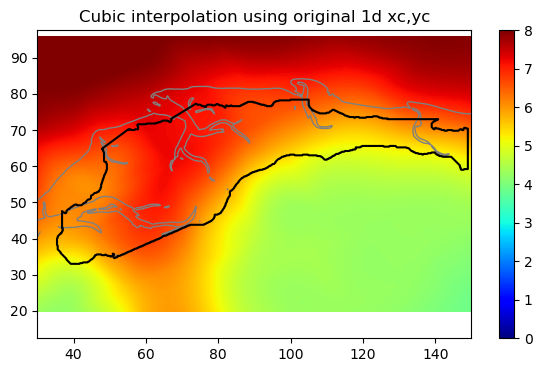

In [59]:
#plot using model vel coordinates
fig,ax= plt.subplots(1,1,figsize=(7,4))
#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax.pcolormesh(dsv.xc.values/1e3,dsv.yc.values/1e3,values_int_v,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax.contour(dsv.xc.values/1e3,dsv.yc.values/1e3,dsv.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax.axis('equal');ax.axis([30,150,30,80])
#plt.axis([100,120,540,560])
plt.colorbar(aa)
ax.set_title('Cubic interpolation using original 1d xc,yc');

### Get uw and vw interpolated in model velocity grid points

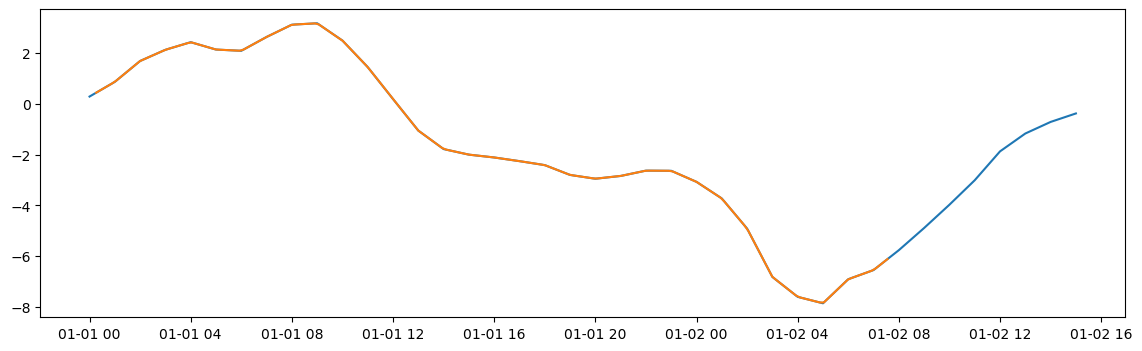

In [11]:
#interpolation in time-------
#
#convert time to float
t_int0=(t_int-ref_time) / np.timedelta64(1,'s')  #dates to interpolate (consistent with tracks)
tw0=(tw-ref_time) / np.timedelta64(1,'s') #wind
#interp
f = interp1d(tw0, dsw.u10.values, axis=0, kind='linear'); u10_t_int=f(t_int0)
f = interp1d(tw0, dsw.v10.values, axis=0, kind='linear'); v10_t_int=f(t_int0)
#
#check interpolation
plt.figure(figsize=(14,4))
plt.plot(tw[:40],dsw.u10.values[:40,32,19])
plt.plot(t_int[:200],u10_t_int[:200,32,19])

In [84]:
#interpolated wind during t_int---

dsout0 = xr.Dataset()
#global coords and attrs---
dsout0.coords["time"] = t_int
dsout0.coords["y"] = dsw.lat.values
dsout0["y"].attrs['description'] = 'latitude'
dsout0.coords["x"] =  dsw.lon.values
dsout0["x"].attrs['description'] = 'longitude'
#
#variables---
#
dsout0["u10"] = (("time","y","x"),u10_t_int)
dsout0["u10"].attrs['long_name'] = 'interpolated zonal wind'
dsout0["u10"].attrs['units'] = 'm/s'
#
dsout0["v10"] = (("time","y","x"),v10_t_int)
dsout0["v10"].attrs['long_name'] = 'interpolated meridional wind'
dsout0["v10"].attrs['units'] = 'm/s'
dsout0.close()

#selecting only the dates of deployment---
#below = t_dep
dsout_int_dep=dsout0.isel(time=range(0,len(t_int)-1,int(m2/nt_int))) #to discard the values during the begining of next year

In [86]:
#resample to make avg during interval of computation of the net displacement---
#make avg during the interval of displacement (right border of interval open)
#
#using numpy----
nt_interval=int(m2/nt_int) #points in the m2 interval (left border of interval open)
nt_mean=(len(t_int)-1)//nt_interval #final shape after mean in the interval
u10_t_int_mean=np.reshape(u10_t_int[:-1,...],(nt_mean,nt_interval,len(dsw.lat),len(dsw.lon)))                        
u10_t_int_mean=u10_t_int_mean.mean(axis=1)
v10_t_int_mean=np.reshape(v10_t_int[:-1,...],(nt_mean,nt_interval,len(dsw.lat),len(dsw.lon)))                        
v10_t_int_mean=v10_t_int_mean.mean(axis=1)
#
#not working well with resample of xarray----
#res=int(nt_int+m2)
#dsout_m2_avg=dsout.resample(time=f'{res}s',closed="right")#.mean(dim='time');
#print(t_dep[:5])
#for i in dsout_m2_avg: print(i)
#
#times are referenced with the date of deployment (the begin of the m2 interval of the displacement)
t_mean=t_dep

#xarray---
dsout_int_mean_dep = xr.Dataset()
#global coords and attrs---
dsout_int_mean_dep.coords["time"] = t_mean
dsout_int_mean_dep.coords["y"] = dsw.lat.values
dsout_int_mean_dep["y"].attrs['description'] = 'latitude'
dsout_int_mean_dep.coords["x"] =  dsw.lon.values
dsout_int_mean_dep["x"].attrs['description'] = 'longitude'
#
#variables---
#
dsout_int_mean_dep["u10"] = (("time","y","x"),u10_t_int_mean)
dsout_int_mean_dep["u10"].attrs['long_name'] = 'interpolated zonal wind'
dsout_int_mean_dep["u10"].attrs['units'] = 'm/s'
#
dsout_int_mean_dep["v10"] = (("time","y","x"),v10_t_int_mean)
dsout_int_mean_dep["v10"].attrs['long_name'] = 'interpolated meridional wind'
dsout_int_mean_dep["v10"].attrs['units'] = 'm/s'
dsout_int_mean_dep.close()

In [87]:
#correlation of spatial mean wind in the m2 interval with the value at the begin of the interval (time of deployment)
a=(u10_t_int_mean**2+v10_t_int_mean**2)**.5
a=np.mean(a,axis=(1,2))
b=(dsout_int_dep.u10[:,...].values**2+dsout_int_dep.u10[:,...].values**2)**.5
b=np.mean(b,axis=(1,2))
print(np.corrcoef(a,b)[0,1])
#
#correlation of mean wind in the m2 interval with the value at the end of the interval
a=(u10_t_int_mean**2+v10_t_int_mean**2)**.5
a=np.mean(a,axis=(1,2))[:-1]
b=(dsout_int_dep.u10[:,...].values**2+dsout_int_dep.u10[:,...].values**2)**.5
b=np.mean(b,axis=(1,2))[1:]
print(np.corrcoef(a,b)[0,1])

0.6432555603617709
0.6899314103812432


In [174]:
# def autocorr(x):
#     #corr=np.correlate(x-x.mean(),x-x.mean(),mode='full')[-len(x.time):]
#     #corr=corr/corr[0] #normalize with its variance
#     return xr.cov(x,x)
# ws_mean=ws.mean(dim=('lon','lat')).sel(time=range("2009","2010"))
# ws_mean_corr=ws_mean.groupby('time.month').apply(autocorr)

In [155]:
def get_autocorr(ws_xr,tw):
    
    #select only 2009
    #
    ws_xr=ws_xr.where(ws_xr.time<np.datetime64(str(year+1)),drop=True)
    #for spatial mean wind---
    #ws_mean=ws.mean(dim=('lon','lat')).where(ws.time<np.datetime64(str(year+1)),drop=True)
    #below the same as above
    #ws_mean=ws.mean(dim=('lon','lat')).where(ws.time<np.datetime64(str(year+1)),np.nan).dropna(dim='time')
    #ws_mean=ws.mean(dim=('lon','lat')).sel(time=slice(f"{year}",f"{year}-12-31T23:59:59.9999"))
    #
    dtw=np.diff(tw) / np.timedelta64(1,'s')
    dtw=dtw[0]/3600 #=1h
    #
    #num time steps for the month with less data (February)
    #we will set the length of the lag correlation of all the months to this value
    ntcor=int(24/dtw*28) #correct when using bi-sisesto days!!!
    #
    #compute lag correlation for each month
    a=ws_xr.groupby('time.month') #group data in months
    autocorr=[]
    for label, x in ws_xr.groupby('time.month'):
        #print(label)
        val0=np.correlate(x-x.mean(),x-x.mean(),mode='full')[-len(x.time):] #pad with zeros when lag time series
        val0/=val0[0] #normalized autocorrelation
        autocorr.append(val0[:ntcor])
    autocorr=np.array(autocorr) #(12,lag)
    tlag=np.arange(0,autocorr.shape[1]*dtw,dtw)/24 #days
    months=np.arange(1,13)

    #np.correlate does below:
    # avg=x.mean().values; var=np.sum((x.values-avg)**2)
    # val=x-avg; val=val.values
    # cor=[]
    # for lag in range(autocorr.shape[1]):
    #     if lag==0: cor.append(1)
    #     else: cor.append(np.sum(val[:-lag]*val[lag:])/var)
    # cor=np.array(cor)
    # #both are the same
    # plt.plot(tlag,cor,'b')
    # plt.plot(tlag,autocorr[-1,:],'r')
    
    return months,tlag,autocorr

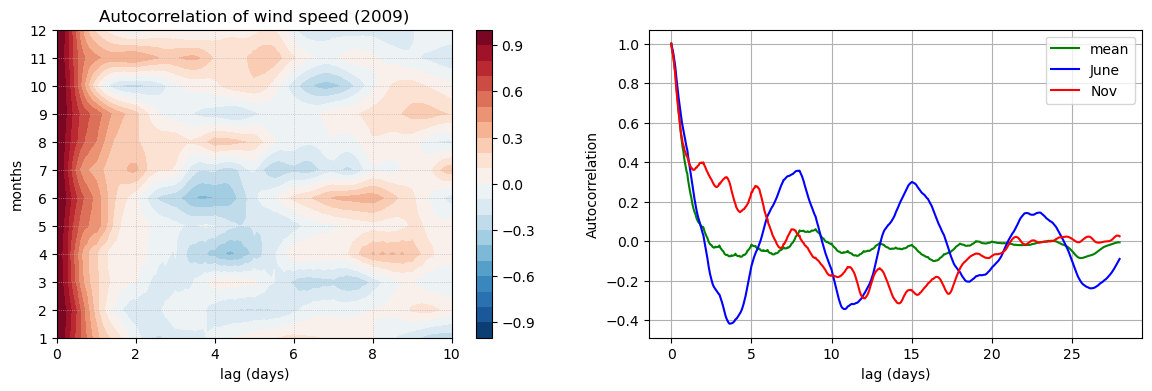

In [163]:
#all wind domain spatial avg---
months,tlag,autocorr=get_autocorr(ws.mean(dim=('lon','lat')),tw) 
#
fig,(ax,ax1)=plt.subplots(1,2,figsize=(14,4))
#
cb=ax.contourf(tlag,months,autocorr,levels=np.arange(-1,1.1,.1),cmap='RdBu_r');plt.colorbar(cb,ax=ax)
ax.set_xlim(0,10);ax.set_xlabel('lag (days)');ax.set_ylabel("months");ax.set_title(f"Autocorrelation of wind speed ({year})");
ax.set_yticks(months); ax.grid(lw=.5,ls=':')
#
ax1.plot(tlag,autocorr.mean(axis=0),label='mean',c='g')
ax1.plot(tlag,autocorr[5,:],label='June',c='b')
ax1.plot(tlag,autocorr[10,:],label='Nov',c='r')
ax1.grid();ax1.set_xlabel('lag (days)');ax1.set_ylabel('Autocorrelation')
ax1.legend()

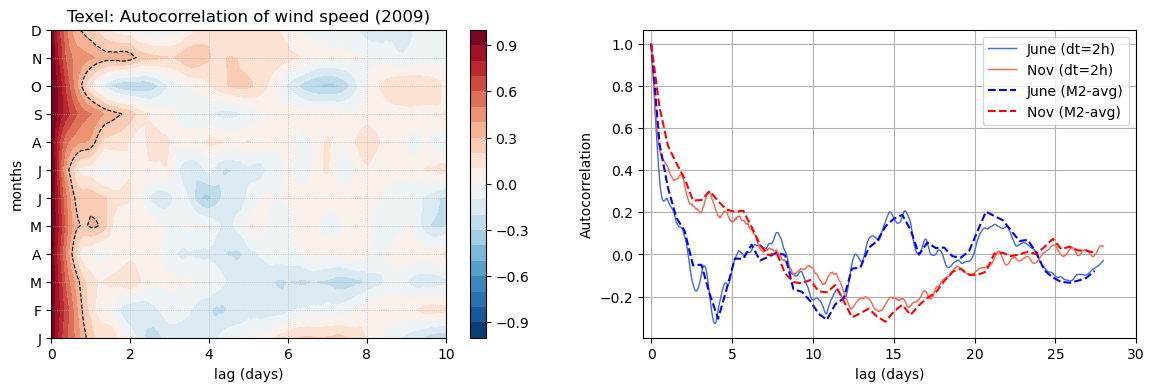

In [228]:
#texel---
months,tlag,autocorrt=get_autocorr(ws.isel(lon=ixt,lat=iyt),tw)  #2h data
a=((dsout_int_mean_dep.u10**2+dsout_int_mean_dep.v10**2)**.5).isel(x=ixt,y=iyt) #m2-avg data
_,tlag_t_int,autocorrt_t_int=get_autocorr(a,a.time) 
#
fig,(ax,ax1)=plt.subplots(1,2,figsize=(14,4))
#
time_ticklabels=['J','F','M','A','M','J','J','A','S','O','N','D']
cb=ax.contourf(tlag,months,autocorrt,levels=np.arange(-1,1.1,.1),cmap='RdBu_r');plt.colorbar(cb,ax=ax)
ax.contour(tlag,months,autocorrt,[.3],colors='k',linestyles='--',linewidths=.8)
ax.set_xlim(0,10);ax.set_xlabel('lag (days)');ax.set_ylabel("months");ax.set_title(f"Texel: Autocorrelation of wind speed ({year})");
ax.set_yticks(months);ax.set_yticklabels(time_ticklabels)#;ax.set_ylim([t[0],t[-1]])
ax.grid(lw=.5,ls=':')
#
#ax1.plot(tlag,autocorrt.mean(axis=0),label='mean',c='g')
ax1.plot(tlag,autocorrt[5,:],c='royalblue',label='June (dt=2h)',lw=1)
ax1.plot(tlag,autocorrt[10,:],c='tomato',label='Nov (dt=2h)',lw=1)
ax1.plot(tlag_t_int,autocorrt_t_int[5,:],'--b',label='June (M2-avg)',lw=1.5)
ax1.plot(tlag_t_int,autocorrt_t_int[10,:],'--r',label='Nov (M2-avg)',lw=1.5)
ax1.grid();ax1.set_xlabel('lag (days)');ax1.set_ylabel('Autocorrelation')
ax1.legend();ax1.set_xlim(-.5,30);

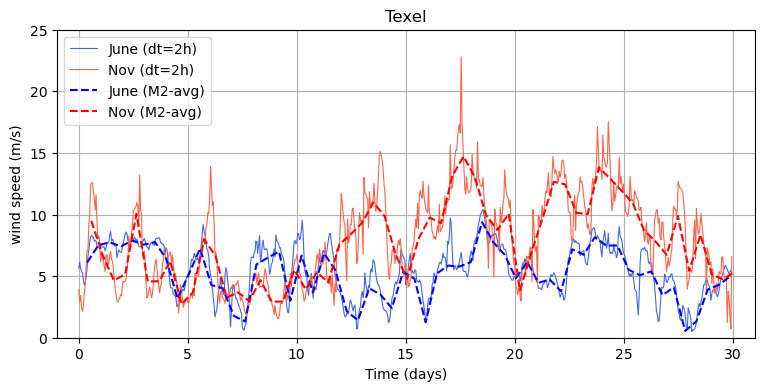

In [233]:
#with 2h original data---
ws_june=ws.isel(lon=ixt,lat=iyt).sel(time=slice(f"{year}-06-01",f"{year}-06-30"))
ws_nov=ws.isel(lon=ixt,lat=iyt).sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
t_june=(ws_june.time-np.datetime64(f"{year}-06-01")) /np.timedelta64(1,'D')
t_nov=(ws_nov.time-np.datetime64(f"{year}-11-01")) /np.timedelta64(1,'D')
#with values every time dep---
# ws_t_int=((dsout_int_dep.u10**2+dsout_int_dep.v10**2)**.5).isel(x=ixt,y=iyt)
# ws_june2=ws_t_int.sel(time=slice(f"{year}-06-01",f"{year}-06-30"))
# ws_nov2=ws_t_int.sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
# t_june2=(ws_june2.time-np.datetime64(f"{year}-06-01")) /np.timedelta64(1,'D')
# t_nov2=(ws_nov2.time-np.datetime64(f"{year}-11-01")) /np.timedelta64(1,'D')
#
#with avg in m2 interval of net displacement---
ws_t_int=((dsout_int_mean_dep.u10**2+dsout_int_mean_dep.v10**2)**.5).isel(x=ixt,y=iyt)
ws_june3=ws_t_int.sel(time=slice(f"{year}-06-01",f"{year}-06-30"))
ws_nov3=ws_t_int.sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
t_june3=(ws_june3.time-np.datetime64(f"{year}-06-01")+np.timedelta64(m2//2,'s')) /np.timedelta64(1,'D')
t_nov3=(ws_nov3.time-np.datetime64(f"{year}-11-01")+np.timedelta64(m2//2,'s')) /np.timedelta64(1,'D')
#
plt.figure(figsize=(9,4))
plt.plot(t_june,ws_june,c='royalblue',label='June (dt=2h)',lw=.8)
plt.plot(t_nov,ws_nov,c='tomato',label='Nov (dt=2h)',lw=.8)
#plt.plot(t_june2,ws_june2,'c',label='June')
#plt.plot(t_nov2,ws_nov2,'y',label='Nov')
plt.plot(t_june3,ws_june3,'--b',label='June (M2-avg)',lw=1.5)
plt.plot(t_nov3,ws_nov3,'--r',label='Nov (M2-avg)',lw=1.5)
plt.grid();plt.legend();plt.ylim(0,25);plt.xlim(-1,31)
plt.xlabel("Time (days)"); plt.ylabel("wind speed (m/s)"); plt.title("Texel");

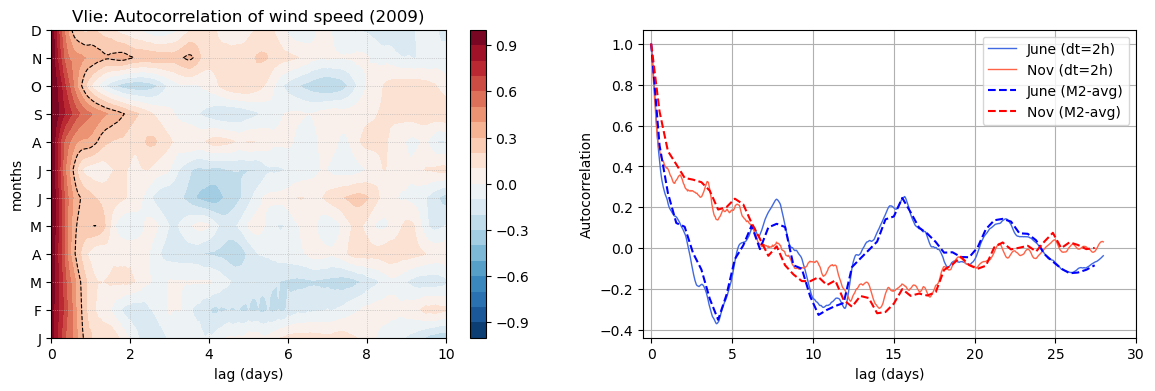

In [234]:
#vlie---
months,tlag,autocorrv=get_autocorr(ws.isel(lon=ixv,lat=iyv),tw)  #2h data
a=((dsout_int_mean_dep.u10**2+dsout_int_mean_dep.v10**2)**.5).isel(x=ixv,y=iyv) #m2-avg data
_,tlag_t_int,autocorrv_t_int=get_autocorr(a,a.time) 
#
fig,(ax,ax1)=plt.subplots(1,2,figsize=(14,4))
#
time_ticklabels=['J','F','M','A','M','J','J','A','S','O','N','D']
cb=ax.contourf(tlag,months,autocorrv,levels=np.arange(-1,1.1,.1),cmap='RdBu_r');plt.colorbar(cb,ax=ax)
ax.contour(tlag,months,autocorrv,[.3],colors='k',linestyles='--',linewidths=.8)
ax.set_xlim(0,10);ax.set_xlabel('lag (days)');ax.set_ylabel("months");ax.set_title(f"Vlie: Autocorrelation of wind speed ({year})");
ax.set_yticks(months);ax.set_yticklabels(time_ticklabels)#;ax.set_ylim([t[0],t[-1]])
ax.grid(lw=.5,ls=':')
#
#ax1.plot(tlag,autocorrt.mean(axis=0),label='mean',c='g')
ax1.plot(tlag,autocorrv[5,:],c='royalblue',label='June (dt=2h)',lw=1)
ax1.plot(tlag,autocorrv[10,:],c='tomato',label='Nov (dt=2h)',lw=1)
ax1.plot(tlag_t_int,autocorrv_t_int[5,:],'--b',label='June (M2-avg)',lw=1.5)
ax1.plot(tlag_t_int,autocorrv_t_int[10,:],'--r',label='Nov (M2-avg)',lw=1.5)
ax1.grid();ax1.set_xlabel('lag (days)');ax1.set_ylabel('Autocorrelation')
ax1.legend();ax1.set_xlim(-.5,30);

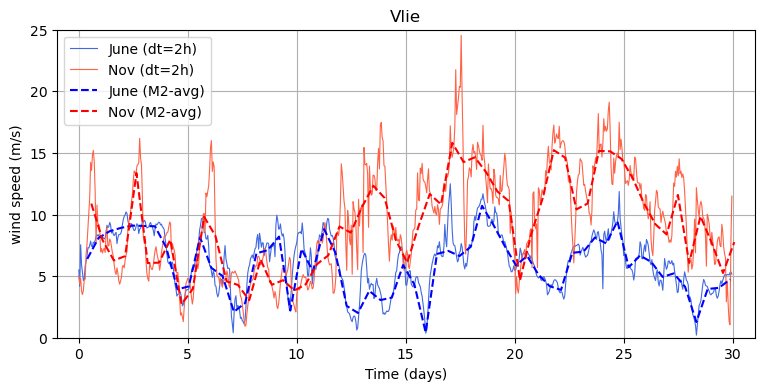

In [235]:
#with 2h original data---
ws_june=ws.isel(lon=ixv,lat=iyv).sel(time=slice(f"{year}-06-01",f"{year}-06-30"))
ws_nov=ws.isel(lon=ixv,lat=iyv).sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
t_june=(ws_june.time-np.datetime64(f"{year}-06-01")) /np.timedelta64(1,'D')
t_nov=(ws_nov.time-np.datetime64(f"{year}-11-01")) /np.timedelta64(1,'D')
#with avg in m2 interval of net displacement---
ws_t_int=((dsout_int_mean_dep.u10**2+dsout_int_mean_dep.v10**2)**.5).isel(x=ixv,y=iyv)
ws_june3=ws_t_int.sel(time=slice(f"{year}-06-01",f"{year}-06-30"))
ws_nov3=ws_t_int.sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
t_june3=(ws_june3.time-np.datetime64(f"{year}-06-01")+np.timedelta64(m2//2,'s')) /np.timedelta64(1,'D')
t_nov3=(ws_nov3.time-np.datetime64(f"{year}-11-01")+np.timedelta64(m2//2,'s')) /np.timedelta64(1,'D')
#
plt.figure(figsize=(9,4))
plt.plot(t_june,ws_june,c='royalblue',label='June (dt=2h)',lw=.8)
plt.plot(t_nov,ws_nov,c='tomato',label='Nov (dt=2h)',lw=.8)
#plt.plot(t_june2,ws_june2,'c',label='June')
#plt.plot(t_nov2,ws_nov2,'y',label='Nov')
plt.plot(t_june3,ws_june3,'--b',label='June (M2-avg)',lw=1.5)
plt.plot(t_nov3,ws_nov3,'--r',label='Nov (M2-avg)',lw=1.5)
plt.grid();plt.legend();plt.ylim(0,25);plt.xlim(-1,31)
plt.xlabel("Time (days)"); plt.ylabel("wind speed (m/s)"); plt.title("Vlie");

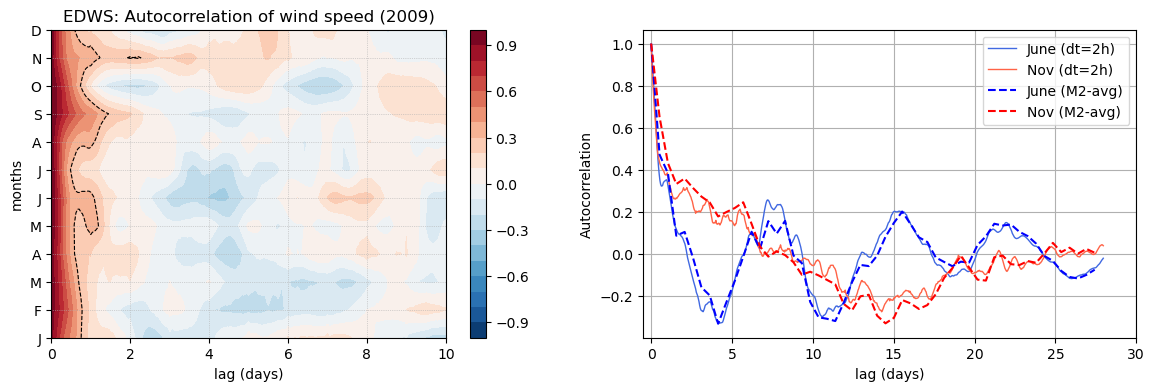

In [236]:
#EDWS---
months,tlag,autocorredw=get_autocorr(ws.isel(lon=ixedw,lat=iyedw),tw)  #2h data
a=((dsout_int_mean_dep.u10**2+dsout_int_mean_dep.v10**2)**.5).isel(x=ixedw,y=iyedw) #m2-avg data
_,tlag_t_int,autocorredw_t_int=get_autocorr(a,a.time) 
#
fig,(ax,ax1)=plt.subplots(1,2,figsize=(14,4))
#
time_ticklabels=['J','F','M','A','M','J','J','A','S','O','N','D']
cb=ax.contourf(tlag,months,autocorredw,levels=np.arange(-1,1.1,.1),cmap='RdBu_r');plt.colorbar(cb,ax=ax)
ax.contour(tlag,months,autocorredw,[.3],colors='k',linestyles='--',linewidths=.8)
ax.set_xlim(0,10);ax.set_xlabel('lag (days)');ax.set_ylabel("months");ax.set_title(f"EDWS: Autocorrelation of wind speed ({year})");
ax.set_yticks(months);ax.set_yticklabels(time_ticklabels)#;ax.set_ylim([t[0],t[-1]])
ax.grid(lw=.5,ls=':')
#
#ax1.plot(tlag,autocorrt.mean(axis=0),label='mean',c='g')
ax1.plot(tlag,autocorredw[5,:],c='royalblue',label='June (dt=2h)',lw=1)
ax1.plot(tlag,autocorredw[10,:],c='tomato',label='Nov (dt=2h)',lw=1)
ax1.plot(tlag_t_int,autocorredw_t_int[5,:],'--b',label='June (M2-avg)',lw=1.5)
ax1.plot(tlag_t_int,autocorredw_t_int[10,:],'--r',label='Nov (M2-avg)',lw=1.5)
ax1.grid();ax1.set_xlabel('lag (days)');ax1.set_ylabel('Autocorrelation')
ax1.legend();ax1.set_xlim(-.5,30);

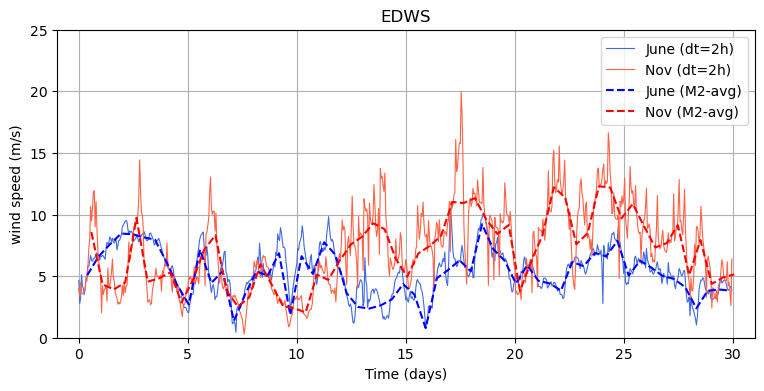

In [237]:
#with 2h original data---
ws_june=ws.isel(lon=ixedw,lat=iyedw).sel(time=slice(f"{year}-06-01",f"{year}-06-30"))
ws_nov=ws.isel(lon=ixedw,lat=iyedw).sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
t_june=(ws_june.time-np.datetime64(f"{year}-06-01")) /np.timedelta64(1,'D')
t_nov=(ws_nov.time-np.datetime64(f"{year}-11-01")) /np.timedelta64(1,'D')
#with avg in m2 interval of net displacement---
ws_t_int=((dsout_int_mean_dep.u10**2+dsout_int_mean_dep.v10**2)**.5).isel(x=ixedw,y=iyedw)
ws_june3=ws_t_int.sel(time=slice(f"{year}-06-01",f"{year}-06-30"))
ws_nov3=ws_t_int.sel(time=slice(f"{year}-11-01",f"{year}-11-30"))
t_june3=(ws_june3.time-np.datetime64(f"{year}-06-01")+np.timedelta64(m2//2,'s')) /np.timedelta64(1,'D')
t_nov3=(ws_nov3.time-np.datetime64(f"{year}-11-01")+np.timedelta64(m2//2,'s')) /np.timedelta64(1,'D')
#
plt.figure(figsize=(9,4))
plt.plot(t_june,ws_june,c='royalblue',label='June (dt=2h)',lw=.8)
plt.plot(t_nov,ws_nov,c='tomato',label='Nov (dt=2h)',lw=.8)
#plt.plot(t_june2,ws_june2,'c',label='June')
#plt.plot(t_nov2,ws_nov2,'y',label='Nov')
plt.plot(t_june3,ws_june3,'--b',label='June (M2-avg)',lw=1.5)
plt.plot(t_nov3,ws_nov3,'--r',label='Nov (M2-avg)',lw=1.5)
plt.grid();plt.legend();plt.ylim(0,25);plt.xlim(-1,31)
plt.xlabel("Time (days)"); plt.ylabel("wind speed (m/s)"); plt.title("EDWS");

In [17]:
%%time
#Spatial interpolation of wind data into projected model grid------

#reshape---
#using avg data in m2 interval
ntw,nyw,nxw=u10_t_int_mean.shape
u10=np.reshape(u10_t_int_mean,(ntw,nyw*nxw))
v10=np.reshape(v10_t_int_mean,(ntw,nyw*nxw))
#
#(using original 2h data)
#ntw,nyw,nxw=dsw.u10.shape
#u10=np.reshape(dsw.u10.values,(ntw,nyw*nxw))[::100,...]
#v10=np.reshape(dsw.v10.values,(ntw,nyw*nxw))[::100,...]
#
#check if reshape the same as flatten (just for the first time)
#val0=dsw.u10.values[0,...].flatten()
#print(np.sum(val0-u10[0,...]))

#grid data----
#because our wind data is to low resolution in contrast with model grid
#cubic spline interpolation seems more suitable
points=np.array([xcw.flatten(),ycw.flatten()]).T
u10 = np.moveaxis(griddata(points, u10.T, (xctp, yctp), method='cubic'),-1,0)
v10= np.moveaxis(griddata(points, v10.T, (xctp, yctp), method='cubic'),-1,0)
np.sum(np.isnan(u10)),np.sum(np.isnan(v10))
#finally select data in domain of velocity
u10=u10[:,iy0:iy1+1,:]; v10=v10[:,iy0:iy1+1,:]

CPU times: user 2min 30s, sys: 1.04 s, total: 2min 31s
Wall time: 2min 31s


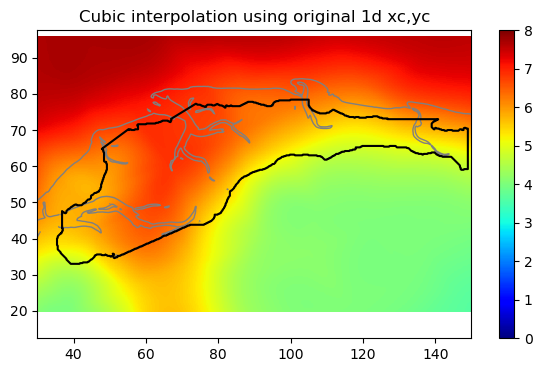

In [18]:
#check above
val=np.mean((u10**2+v10**2)**.5,axis=0)
#
#plot using model vel coordinates
fig,ax= plt.subplots(1,1,figsize=(7,4))
#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax.pcolormesh(dsv.xc.values/1e3,dsv.yc.values/1e3,val,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax.contour(dsv.xc.values/1e3,dsv.yc.values/1e3,dsv.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax.axis('equal');ax.axis([30,150,30,80])
#plt.axis([100,120,540,560])
plt.colorbar(aa)
ax.set_title('Cubic interpolation using original 1d xc,yc');

In [21]:
#save data
dsout = xr.Dataset()
#global coords and attrs---
dsout.coords["time"] = t_mean #=t_dep
dsout["time"].attrs['description'] = 'initial date of the M2 average interval'
dsout.coords["yc"] = dsv.yc.values.astype("float32")
dsout["yc"].attrs['long_name'] = 'y'
dsout["yc"].attrs['units'] = 'm'
dsout.coords["xc"] = dsv.xc.values.astype("float32")
dsout["xc"].attrs['long_name'] = 'x'
dsout["xc"].attrs['units'] = 'm'
#
dsout.attrs["temporal_info"] = f"wind was averaged during the M2(={m2}s) interval of the net displacement, with right border of interval open"
dsout.attrs["spatial_info"] = "wind was cubic-interpolated into the local xc and yc model units"
#
#variables---
#
dsout["u10"] = (("time","yc","xc"),u10.astype("float32"))
dsout["u10"].attrs['long_name'] = 'interpolated wind in model x-direction'
dsout["u10"].attrs['units'] = 'm/s'
#
dsout["v10"] = (("time","yc","xc"),v10.astype("float32"))
dsout["v10"].attrs['long_name'] = 'interpolated wind in model y-direction'
dsout["v10"].attrs['units'] = 'm/s'
#
file_out_nc=f"{year}_avg_wind_during_1M2_and_interp_in_model_xcyc_grid.nc"
dir_out_nc="post_proc_data/wind/"
dsout.to_netcdf(dir_out_nc+file_out_nc)

### get wind data in particle grid

In [45]:
#Spatial interpolation of wind data into grid of displacements------
#build grid (like the one of displacements)
xmin=x0.min();xmax=x0.max();ymin=y0.min();ymax=y0.max()
extend_grid=10 #so from particle min max positions extend grid 10*dx (to not have problems with convolution)
xgrid=np.arange(xmin-dx*1e3*extend_grid,xmax+dx*1e3*(extend_grid+1),dx*1e3,dtype='float32')
ygrid=np.arange(ymin-dy*1e3*extend_grid,ymax+dy*1e3*(extend_grid+1),dy*1e3,dtype='float32')
xgrid0,ygrid0=np.meshgrid(xgrid,ygrid)

In [46]:
#nearest interpolation
#reshape---
ntw,nyw,nxw=dsout.u10.shape
u10g=np.reshape(u10,(ntw,nyw*nxw))
v10g=np.reshape(v10,(ntw,nyw*nxw))

#grid data with nearest----
xx,yy=np.meshgrid(dsout.xc.values,dsout.yc.values)
points=np.array([xx.flatten(),yy.flatten()]).T
u10g = np.moveaxis(griddata(points, u10g.T, (xgrid0, ygrid0), method='nearest'),-1,0)
v10g= np.moveaxis(griddata(points, v10g.T, (xgrid0, ygrid0), method='nearest'),-1,0)
np.sum(np.isnan(u10g)),np.sum(np.isnan(v10g))

(0, 0)

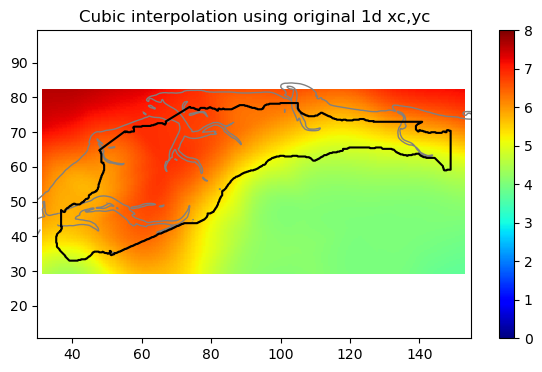

In [49]:
#check above
val=np.mean((u10g**2+v10g**2)**.5,axis=0)
#
#plot using model vel coordinates
fig,ax= plt.subplots(1,1,figsize=(7,4))
#aa=ax[1].contourf(xctl,yctl,values_int,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
aa=ax.pcolormesh(xgrid/1e3,ygrid/1e3,val,vmin=0,vmax=8,shading='auto',cmap='jet') #wind correct orientation
#ws2=ws_avg.sel(lon=slice(4,6.5),lat=slice(52.5,53.75)).values
#aa=ax[1].contourf(xcw2,ycw2,ws2,levels=np.arange(0,8.5,.5),extend='max',cmap='jet') #wind correct orientation
ax.contour(dsv.xc.values/1e3,dsv.yc.values/1e3,dsv.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
ax.plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k') #DWS limits
ax.axis('equal');ax.axis([30,155,30,80])
#plt.axis([100,120,540,560])
plt.colorbar(aa)
ax.set_title('Cubic interpolation using original 1d xc,yc');

In [50]:
#save data
#del dsout1
#dsout1.close()
dsout1 = xr.Dataset()
#global coords and attrs---
dsout1.coords["time"] = t_mean #=t_dep
dsout1["time"].attrs['description'] = 'initial date of the M2 average interval'
dsout1.coords["y"] = ygrid.astype('float32')
dsout1["y"].attrs['long_name'] = 'y'
dsout1["y"].attrs['description'] = 'axis equal to the particle grid y-axis'
dsout1["y"].attrs['units'] = 'm'
dsout1.coords["x"] = xgrid.astype('float32')
dsout1["x"].attrs['long_name'] = 'x'
dsout1["x"].attrs['description'] = 'axis equal to the particle grid x-axis'
dsout1["x"].attrs['units'] = 'm'
#
dsout1.attrs["temporal_info"] = f"wind was averaged during the M2(={m2}s) interval of the net displacement, with right border of interval open"
dsout1.attrs["spatial_info"] = "wind was nearest-interpolated from local xc and yc model units to particle-grid"
#
#variables---
#
dsout1["u10"] = (("time","y","x"),u10g.astype('float32'))
dsout1["u10"].attrs['long_name'] = 'interpolated wind in x-direction'
dsout1["u10"].attrs['units'] = 'm/s'
#
dsout1["v10"] = (("time","y","x"),v10g.astype('float32'))
dsout1["v10"].attrs['long_name'] = 'interpolated wind in y-direction'
dsout1["v10"].attrs['units'] = 'm/s'
#
file_out_nc=f"{year}_avg_wind_during_1M2_and_interp_in_particle_grid.nc"
dir_out_nc=f"post_proc_data/wind/"
dsout1.to_netcdf(dir_out_nc+file_out_nc)